In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas import DataFrame
import matplotlib.pyplot as plt
import csv

In [3]:
root_path = './ErrorLog_Ver5'
df1 = pd.read_csv(f'{root_path}/errorlog0601_0615_edit.csv')  
df2 = pd.read_csv(f'{root_path}/errorlog0616_0630_edit.csv')  
df3 = pd.read_csv(f'{root_path}/errorlog0701_0715_edit.csv')  
df4 = pd.read_csv(f'{root_path}/errorlog0716_0731_edit.csv')  
df5 = pd.read_csv(f'{root_path}/errorlog0801_0814_edit.csv')
df6 = pd.read_csv(f'{root_path}/errorlog0815_0830_edit.csv')
df7 = pd.read_csv(f'{root_path}/errorlog0831_0914_edit.csv')  
df8 = pd.read_csv(f'{root_path}/errorlog0915_0928_edit.csv')  
df9 = pd.read_csv(f'{root_path}/errorlog0929_1012_edit.csv')  
df10 = pd.read_csv(f'{root_path}/errorlog1013_1026_edit.csv')  
df11 = pd.read_csv(f'{root_path}/errorlog1027_1031_edit.csv')

df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11],axis=0, ignore_index=True).drop_duplicates(subset=None, keep='first').reset_index(drop=True)
print(df.shape)
df.head(5)

(18293458, 15)


,EventTime,SessionID,UserID,ErrorEventID,Channel,Country,LV,VipLV,UDID,State,Machine,TotalBet,FeverState,PublishVer,CurChannel
0,1592226275,1eb7833f9639cf7cd01fa676799f042b,2020112439795933,1001,2,ID,94,1,7fa8376654252c1a,LOADING,0,0,"""""","""2.4.5""",2
1,1592226267,23b1bf325c3fbb96735495c413f600e7,2020112427046179,1111100001,2,US,158,3,54d20a83598caa38,"""FISH_HUNTER""",74,0,NONE,"""2.4.5""",2
2,1592226265,f501916348277f876eb0c7694faef5a2,2020112433839517,1009,1,MY,1,1,"""09BAD469-027C-41D8-8046-5FBF228A5D2E""",LOADING,0,0,"""""","""2.4.5""",1
3,1592226248,"""""",2020112443386984,2010,1,VN,0,0,"""AA4A1E2E-1E1A-42DC-A094-71B528BF6CB4""",LOADING,0,0,"""""","""2.4.5""",1
4,1592226241,"""""",2020112443386984,2010,1,VN,0,0,"""AA4A1E2E-1E1A-42DC-A094-71B528BF6CB4""",LOGIN,0,0,"""""","""2.4.5""",1


# Total error count

In [4]:
Year = [2020]
Month = [6,7,8,9,10]

EventTime = df.EventTime

date_dict = {}
for _time in EventTime:
    dt = datetime.fromtimestamp(_time)
    
    if dt.month not in Month:
        continue
    
    t = f"{dt.month:02d}{dt.day:02d}-{dt.hour:02d}~{(dt.hour+1):02d}"
    
    if date_dict.get(t, 0):
        date_dict[t] += 1
    else:
        date_dict[t] = 1

error_date = []
error_count = []
for k in sorted(date_dict.keys()):
    error_date.append(k)
    error_count.append(date_dict[k])
    
print(len(error_date))

3672


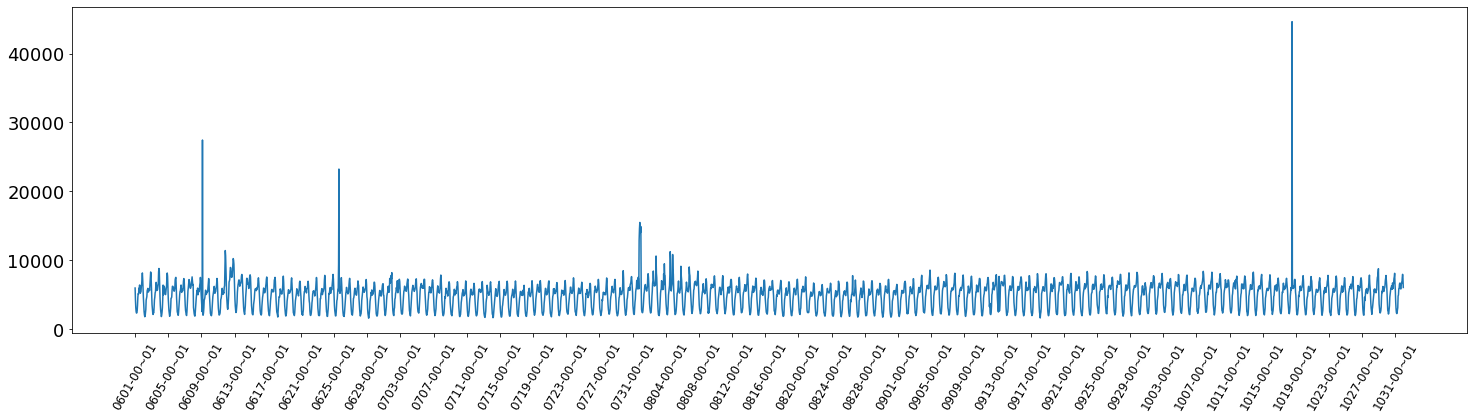

In [5]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [25, 6]
fig = plt.figure()
plt.plot(error_date, error_count)
plt.xticks(error_date[:][::96], fontsize=12, rotation=60)
plt.yticks(fontsize=18)
plt.show()

# Multivariate error count

In [6]:
Date = []
Country = ['TW', 'CN', 'US', 'JP', 'ID', 'PH', 'VN']
State = list(df['State'].unique())
ErrorEventID = ['002', '003', '004']
Column = Country + State + ErrorEventID

multivariate_dict = {}

for i in range(df.shape[0]):
    _time = df.loc[i, 'EventTime']
    _country = df.loc[i, 'Country']
    _state = df.loc[i, 'State']
    _errorID = str(df.loc[i, 'ErrorEventID'])[-3:]
    dt = datetime.fromtimestamp(_time)

    if dt.year not in Year or dt.month not in Month:
        continue

    t = f"{dt.month:02d}{dt.day:02d}-{dt.hour:02d}~{dt.hour+1:02d}"

    ### initialize
    if t not in Date:
        multivariate_dict[t] = {}
        for _col in Column:
            multivariate_dict[t][_col] = 0
        Date.append(t)

    if _country in Country:
        multivariate_dict[t][_country] += 1 
        
    multivariate_dict[t][_state] += 1
    
    if _errorID in ErrorEventID:
        multivariate_dict[t][_errorID] += 1 

print(multivariate_dict['0901-08~09']['TW'])

144


In [7]:
Column.insert(0, 'ErrorTime')
Column.insert(1, 'Total')

In [8]:
with open('multivariate.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=Column)
    writer.writeheader()

    for _time in sorted(Date):
        multivariate_dict[_time]['ErrorTime'] = _time        # insert errortime
        multivariate_dict[_time]['Total'] = date_dict[_time] # insert total error count
        writer.writerow(multivariate_dict[_time])

print('done')

done


# Show multivariate

In [9]:
column = []
_dict = {} # 'feature': [errorcount]

with open('./multivariate.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
    
    column = [c for c in data[0]]
    _dict = { i : [] for i in column }
    
    for row in data[1:]:
        for index in range(0, len(row)):
            col = column[index]
            if index == 0:
                _dict[col].append(row[index])
            else:
                _dict[col].append(int(row[index]))

error_date = _dict['ErrorTime']
del _dict['ErrorTime']

In [ ]:
# print(_dict['"PK_TOURNAMENT_LOBBY"'])
print(_dict['"ARENA_LOBBY"'])

No handles with labels found to put in legend.


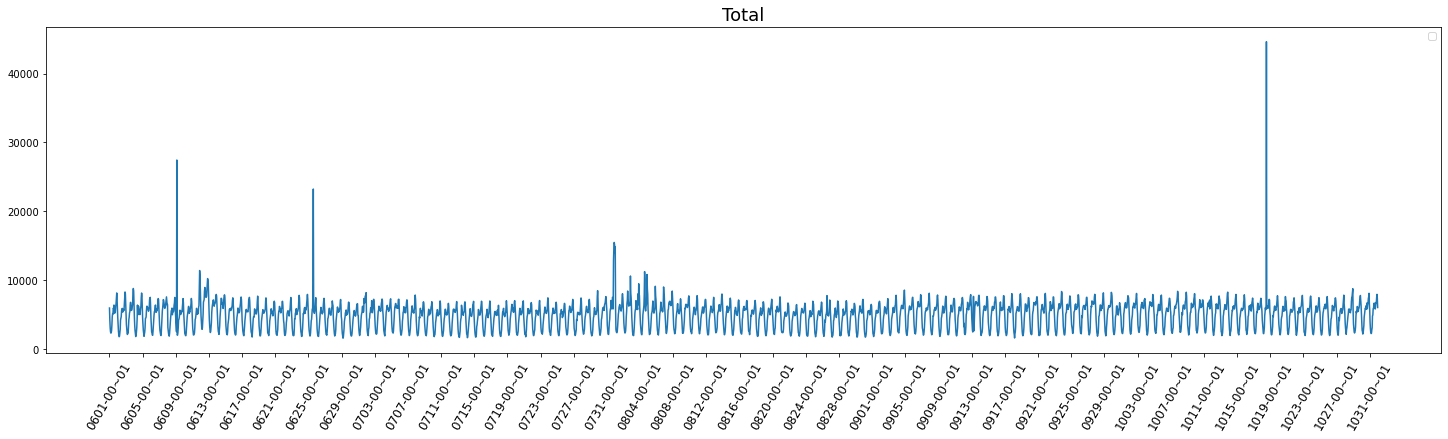

No handles with labels found to put in legend.


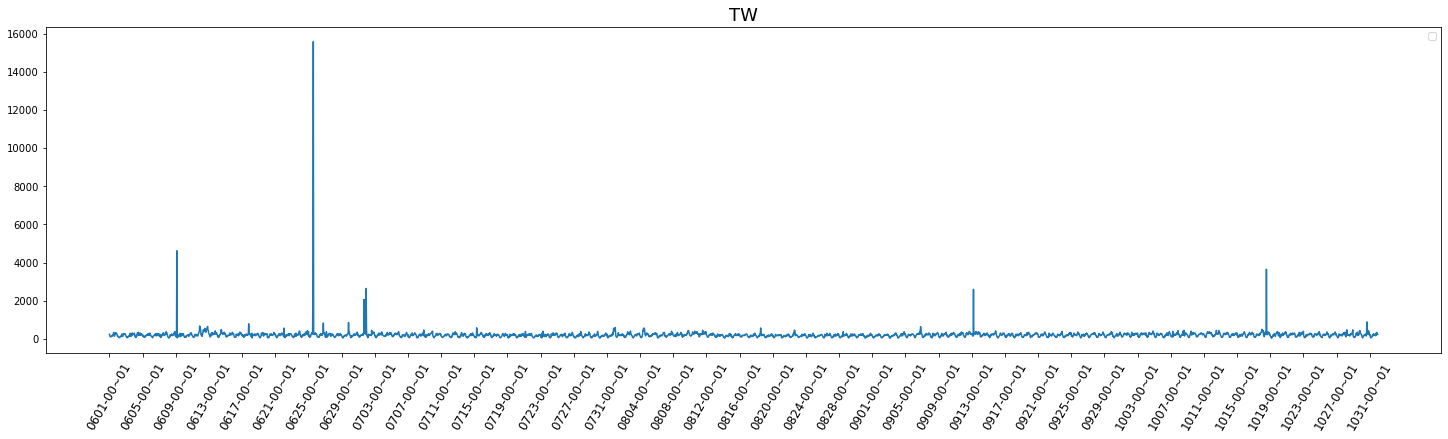

No handles with labels found to put in legend.


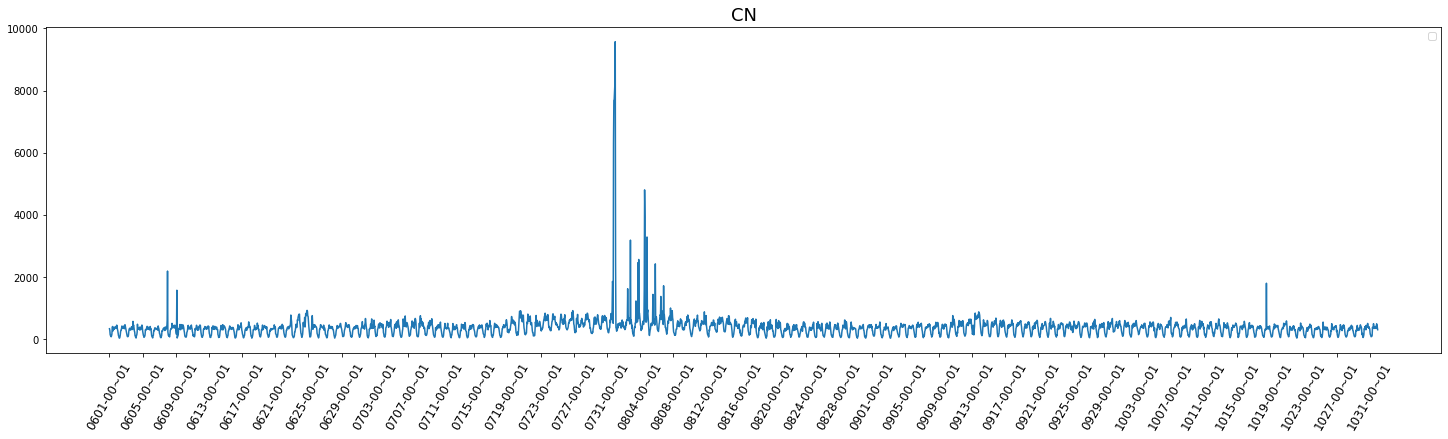

No handles with labels found to put in legend.


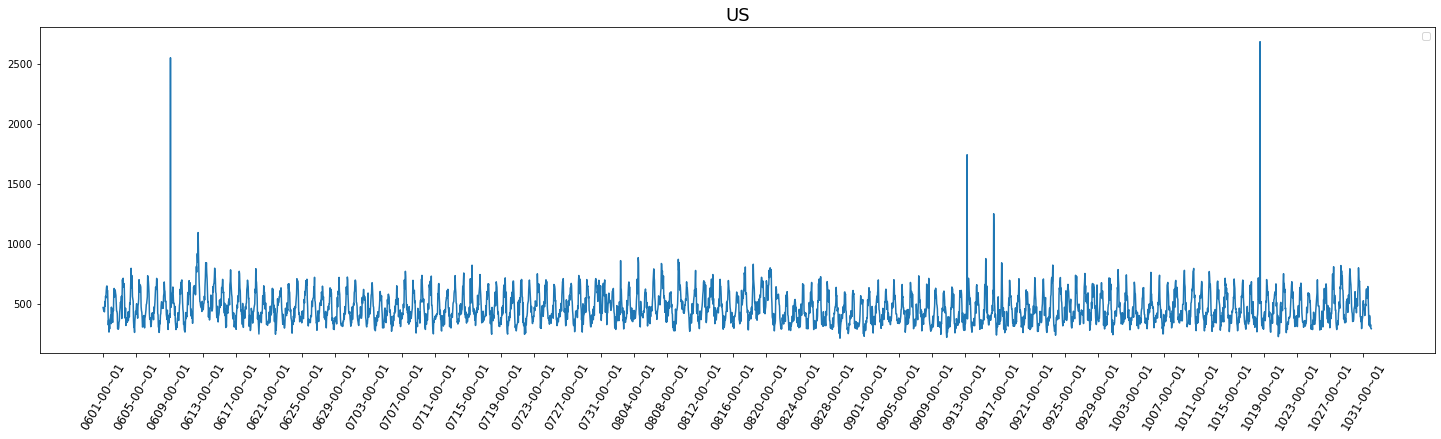

No handles with labels found to put in legend.


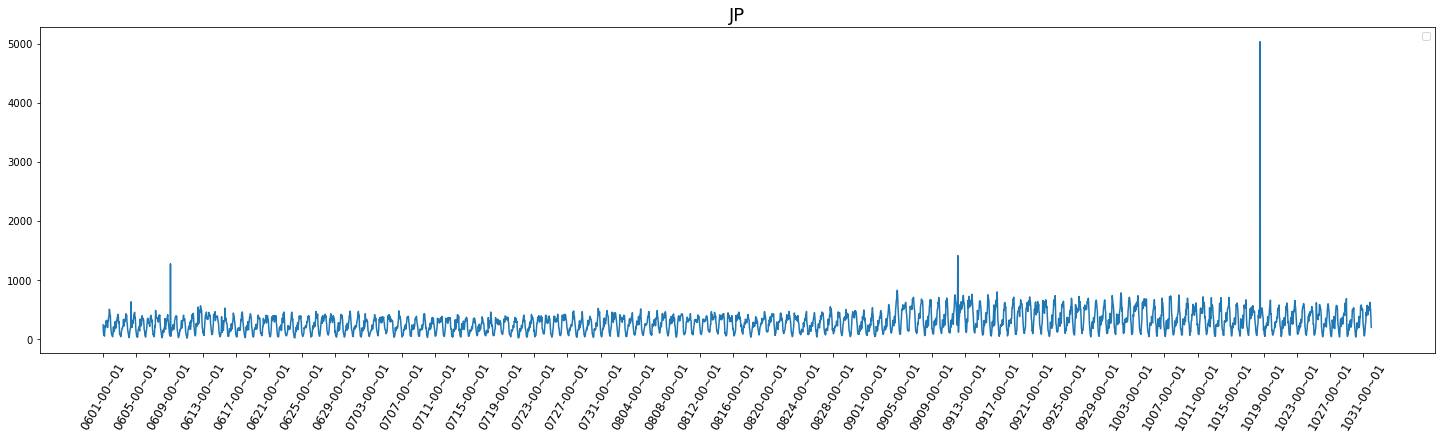

No handles with labels found to put in legend.


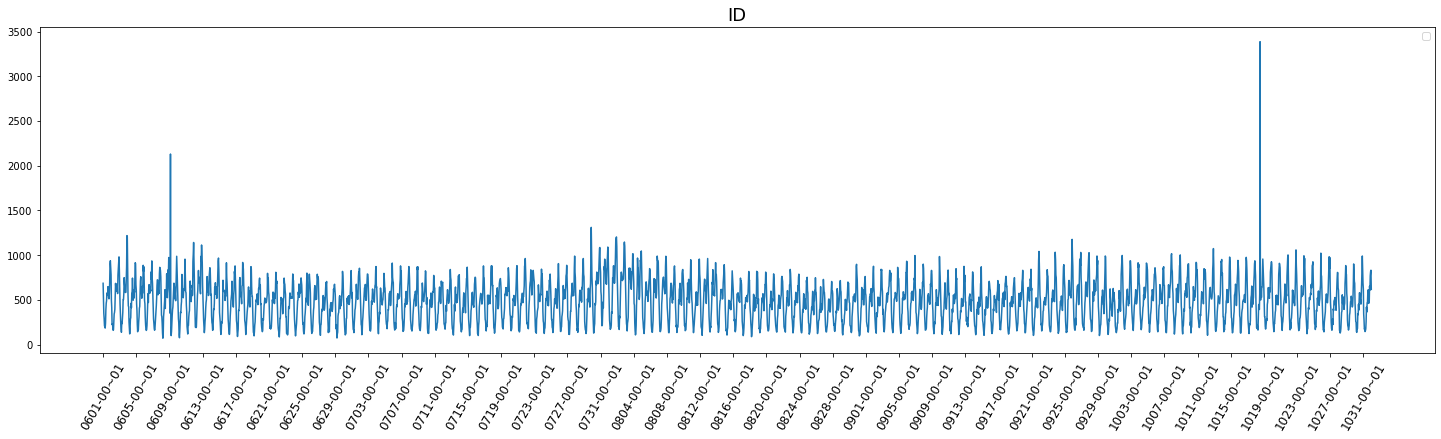

No handles with labels found to put in legend.


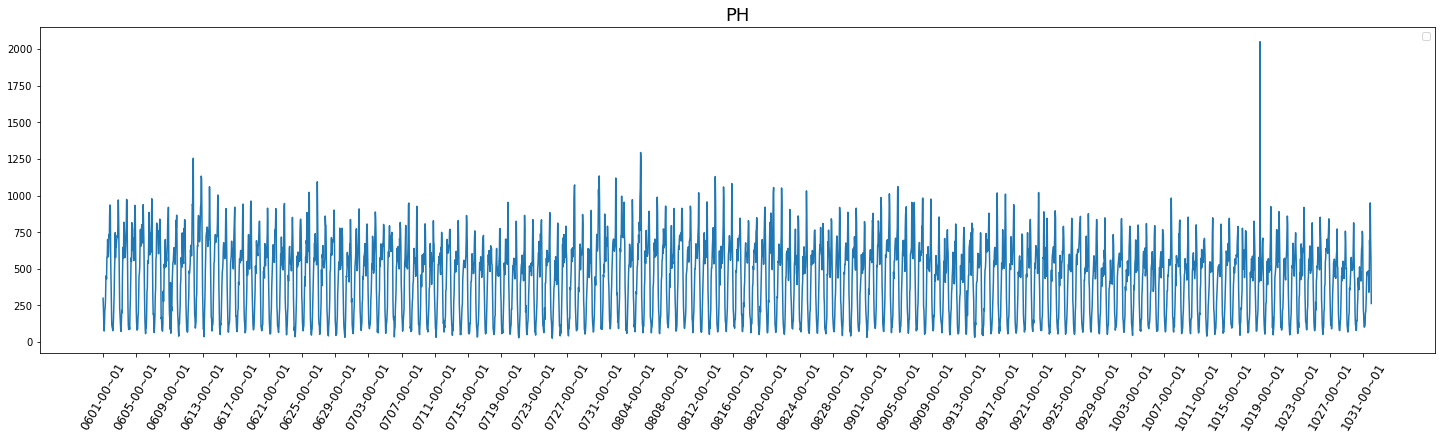

No handles with labels found to put in legend.


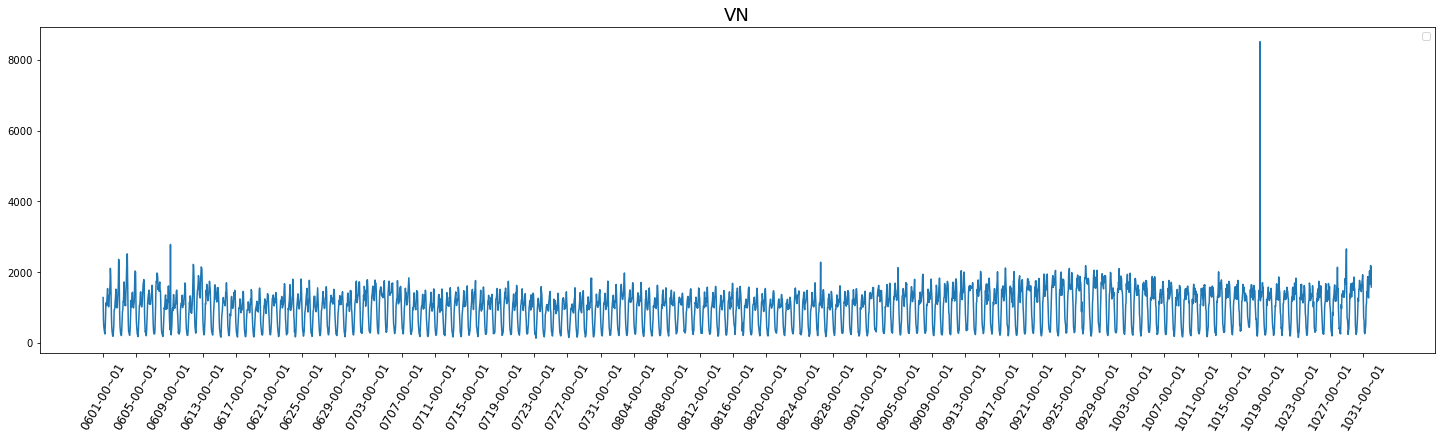

No handles with labels found to put in legend.


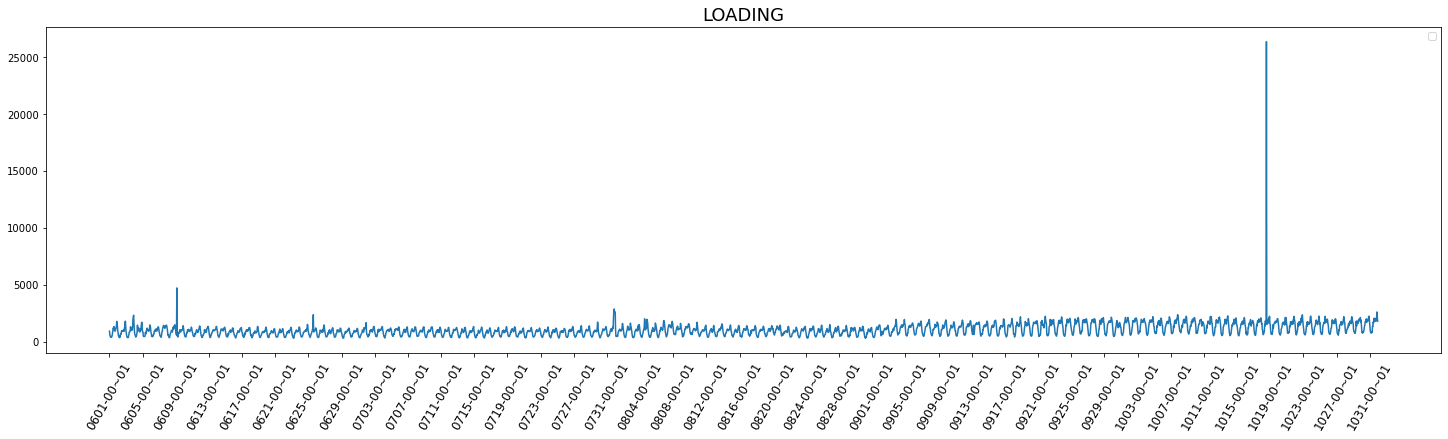

No handles with labels found to put in legend.


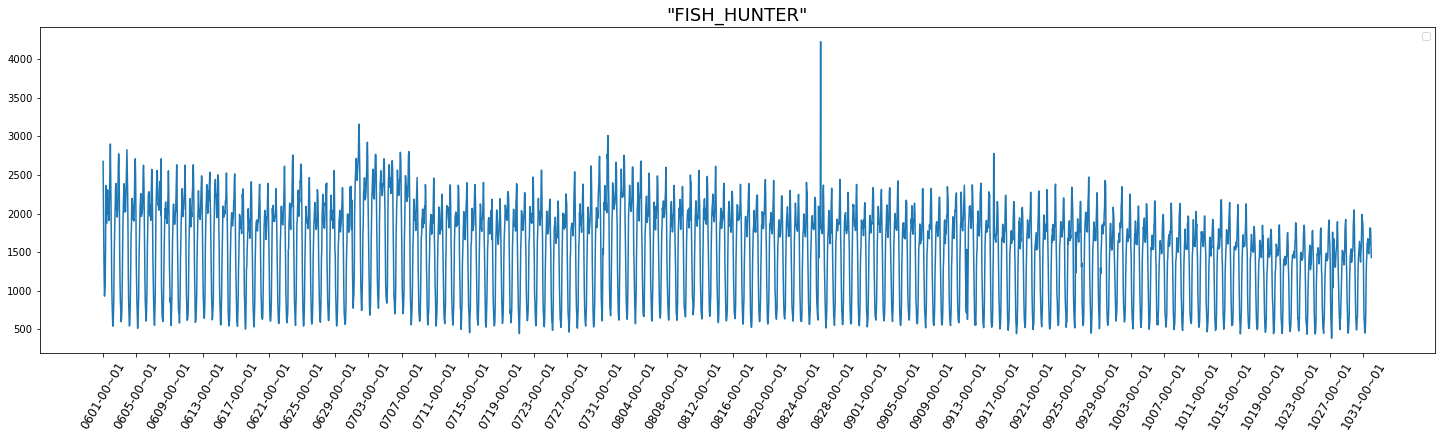

No handles with labels found to put in legend.


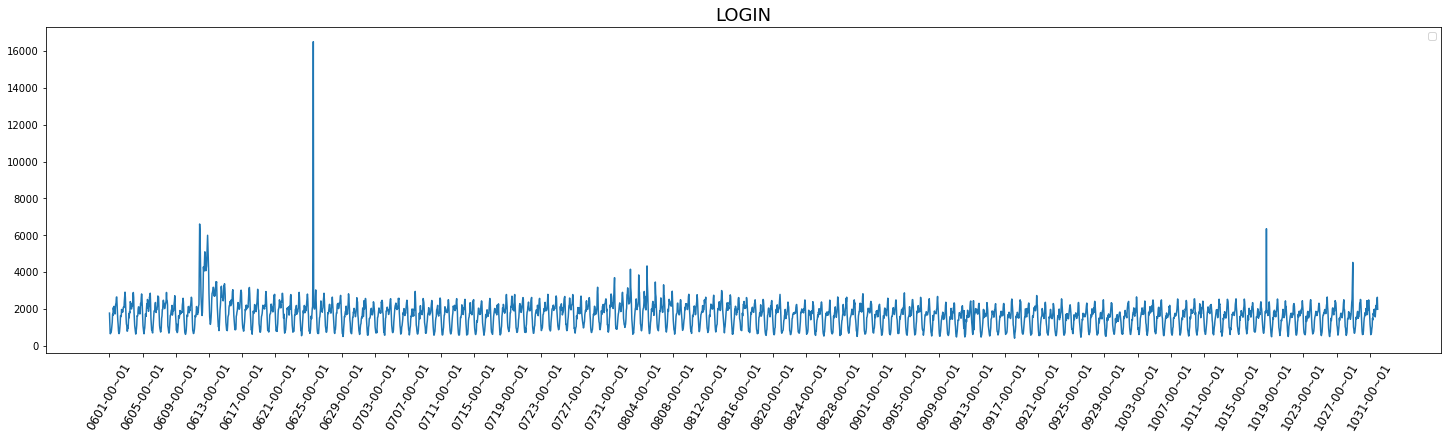

No handles with labels found to put in legend.


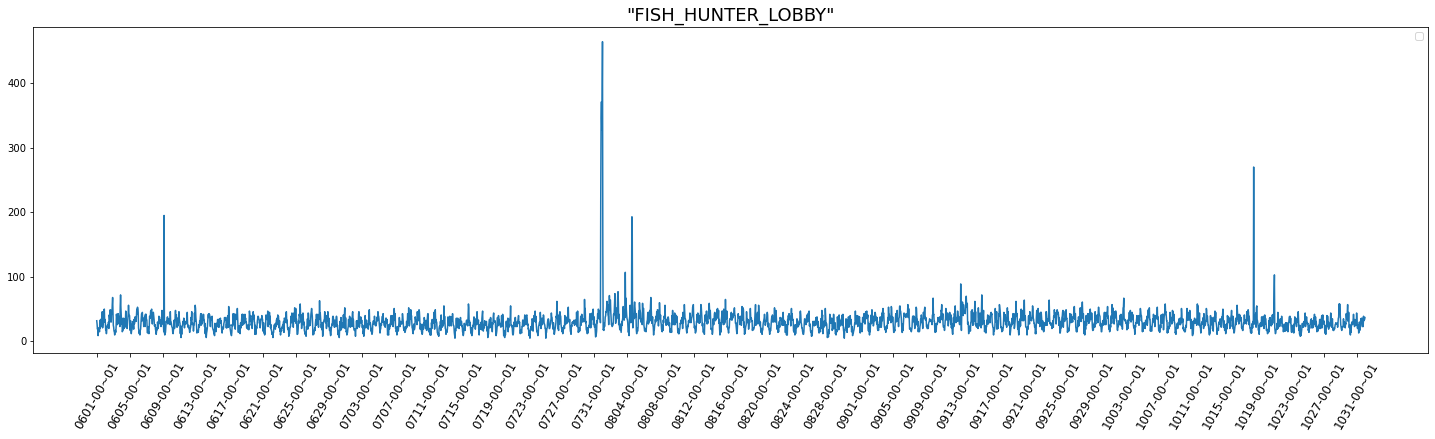

No handles with labels found to put in legend.


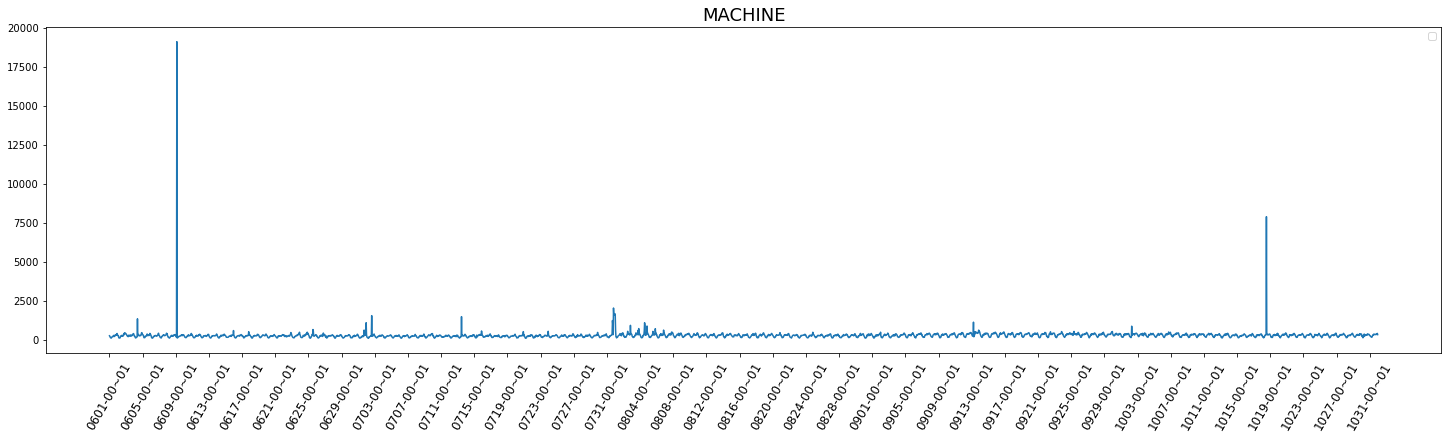

No handles with labels found to put in legend.


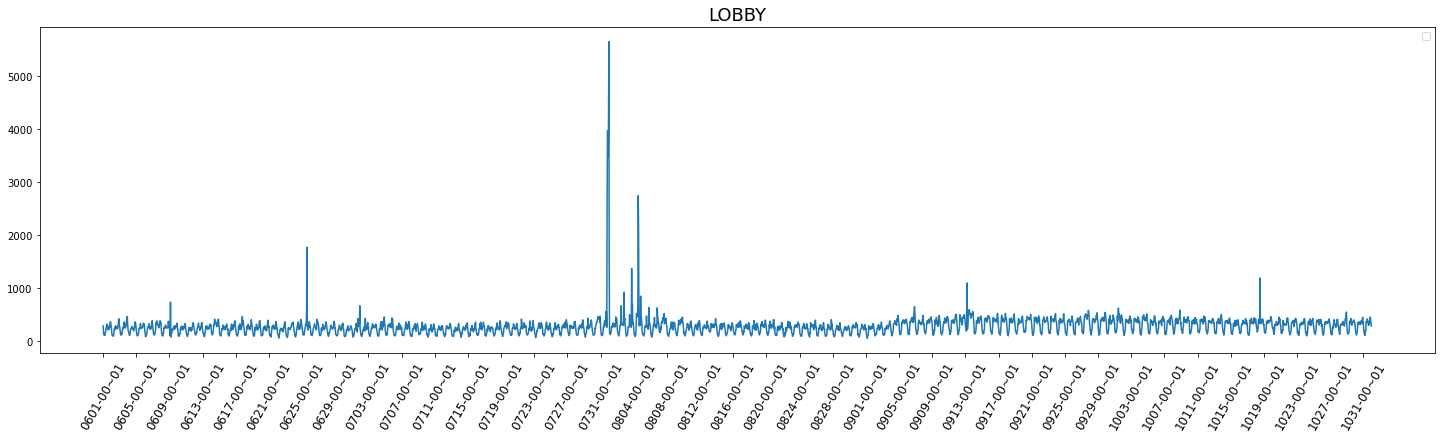

No handles with labels found to put in legend.


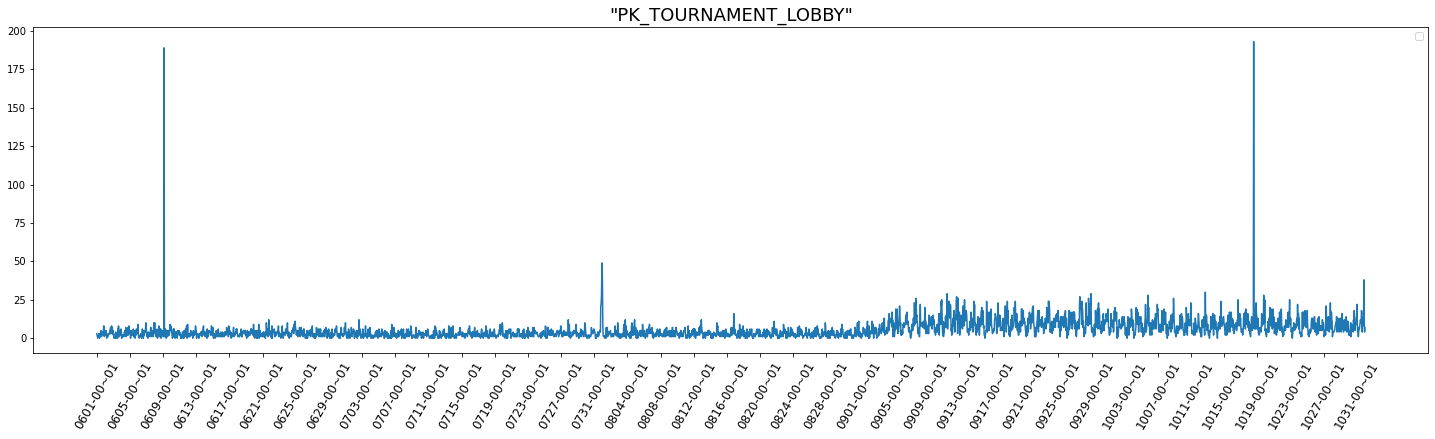

No handles with labels found to put in legend.


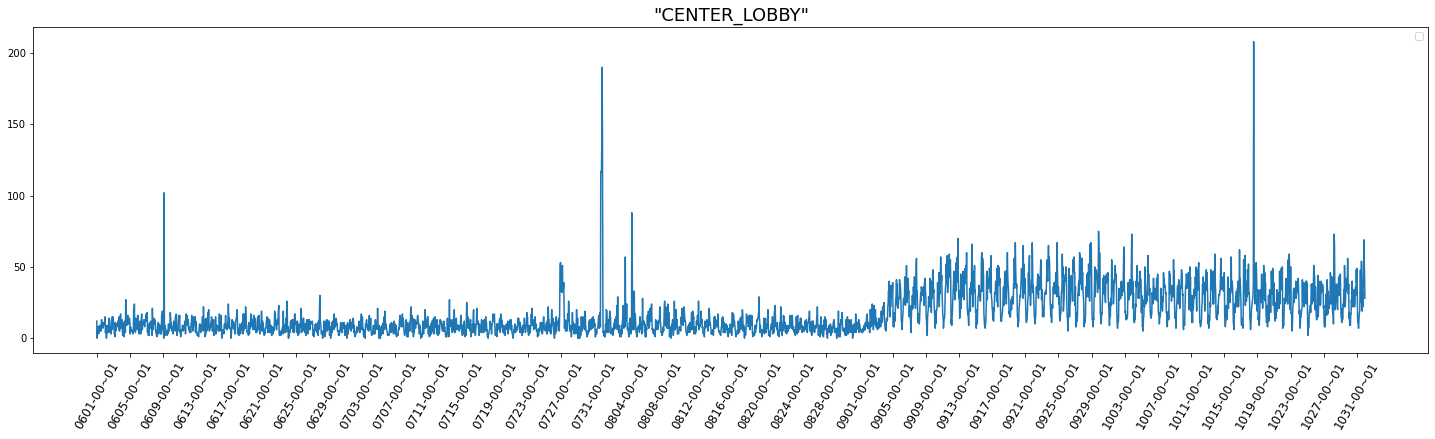

No handles with labels found to put in legend.


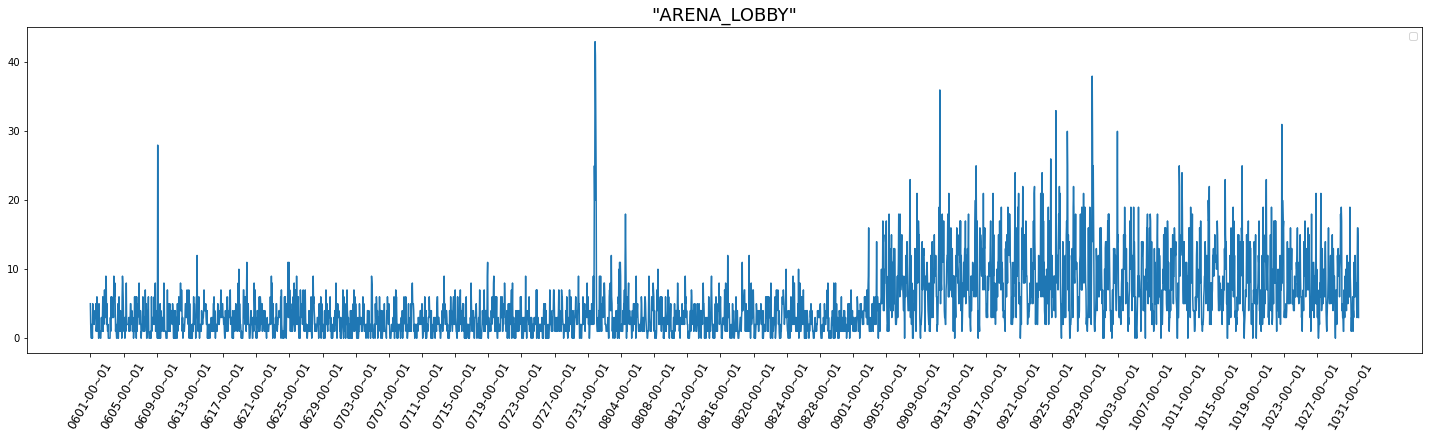

No handles with labels found to put in legend.


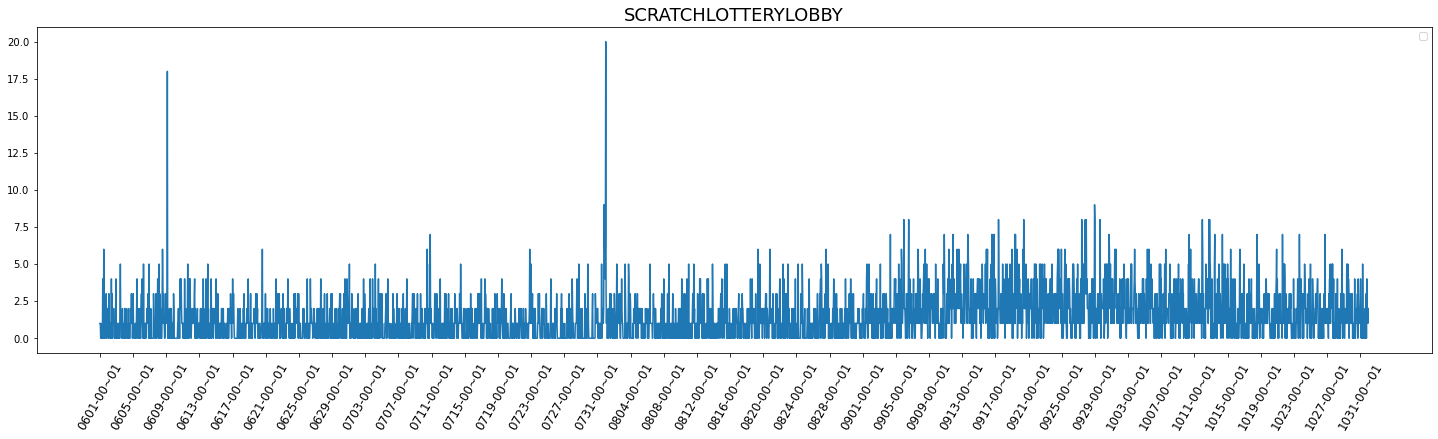

No handles with labels found to put in legend.


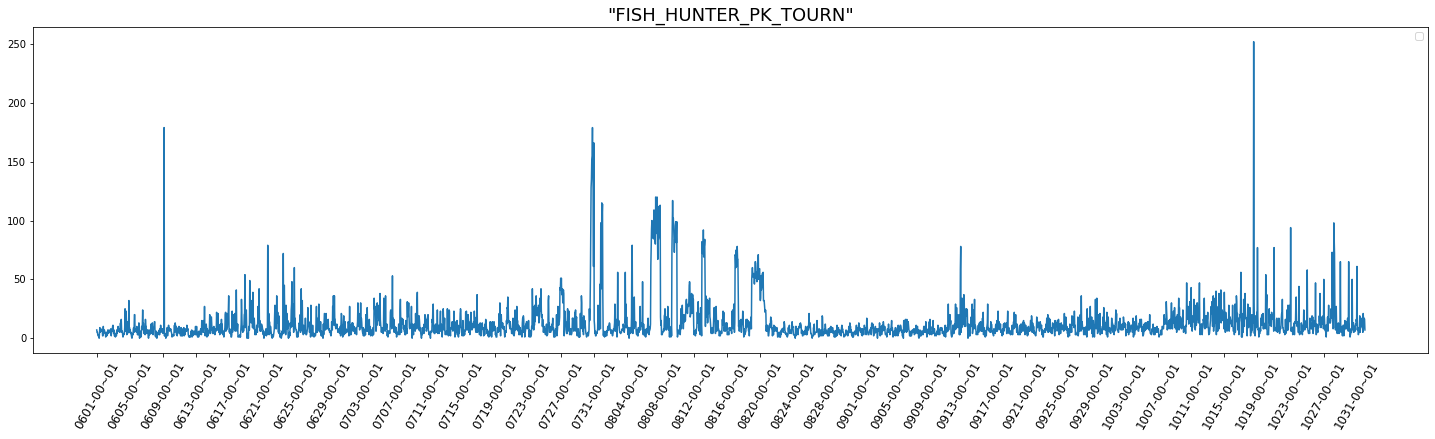

No handles with labels found to put in legend.


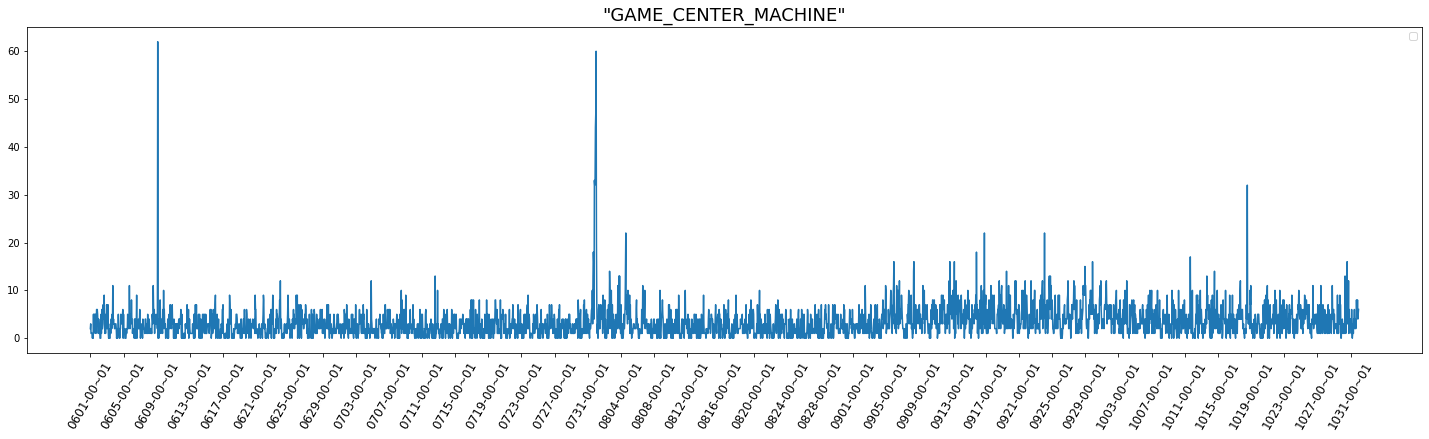

No handles with labels found to put in legend.


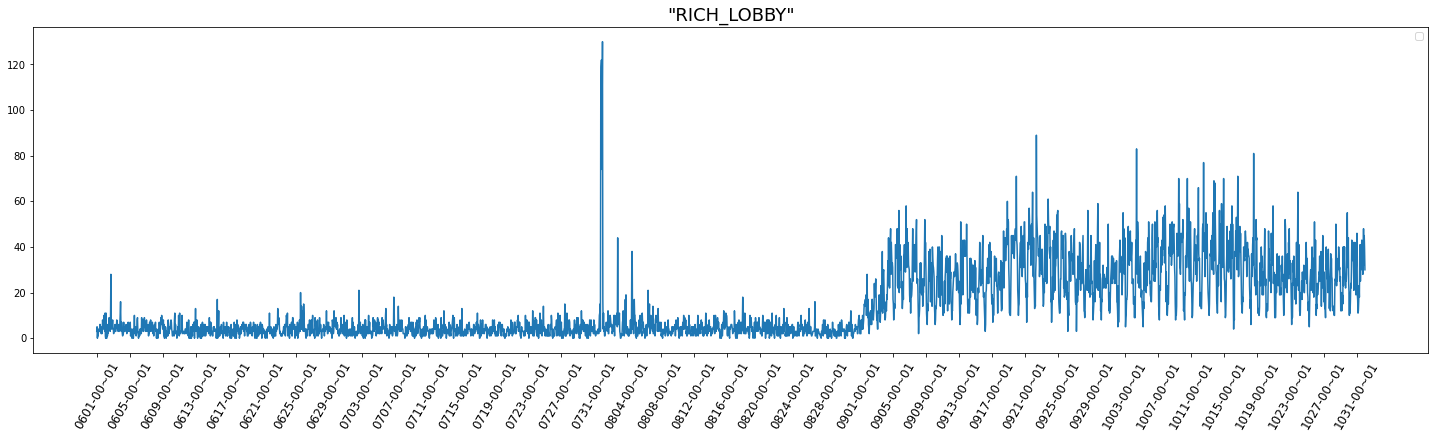

No handles with labels found to put in legend.


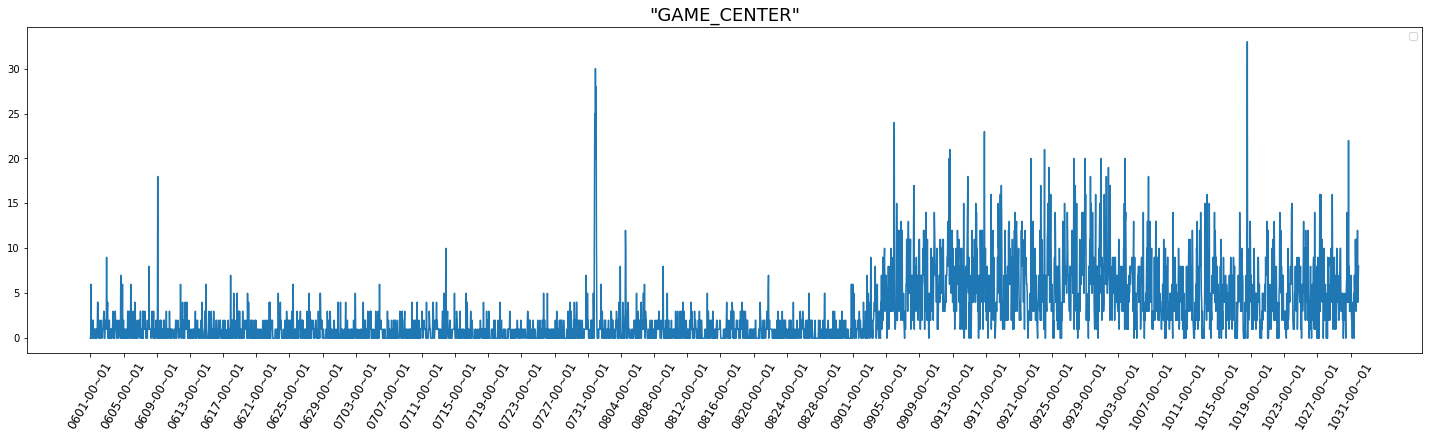

No handles with labels found to put in legend.


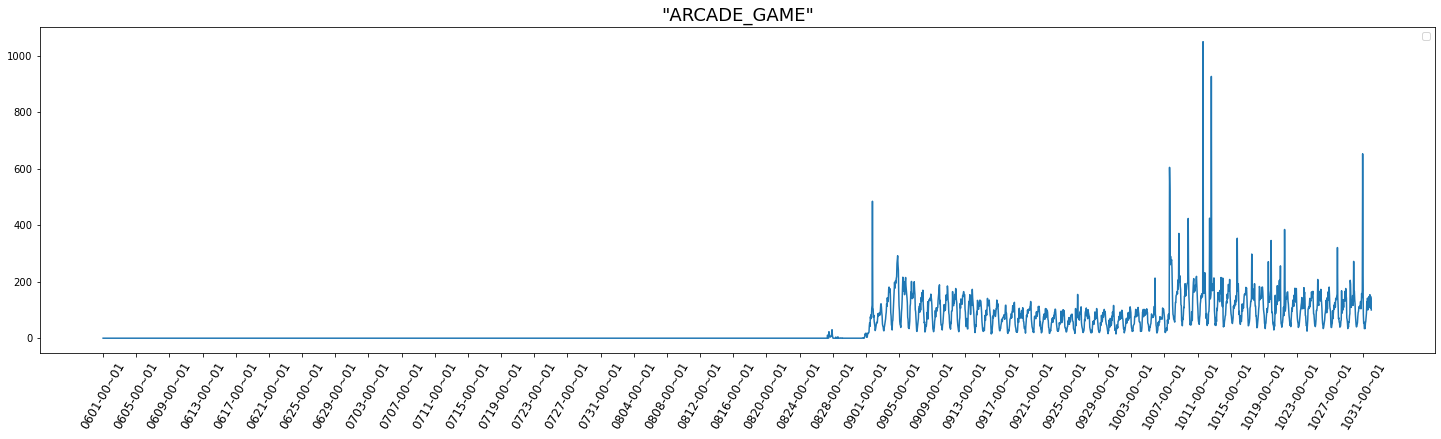

No handles with labels found to put in legend.


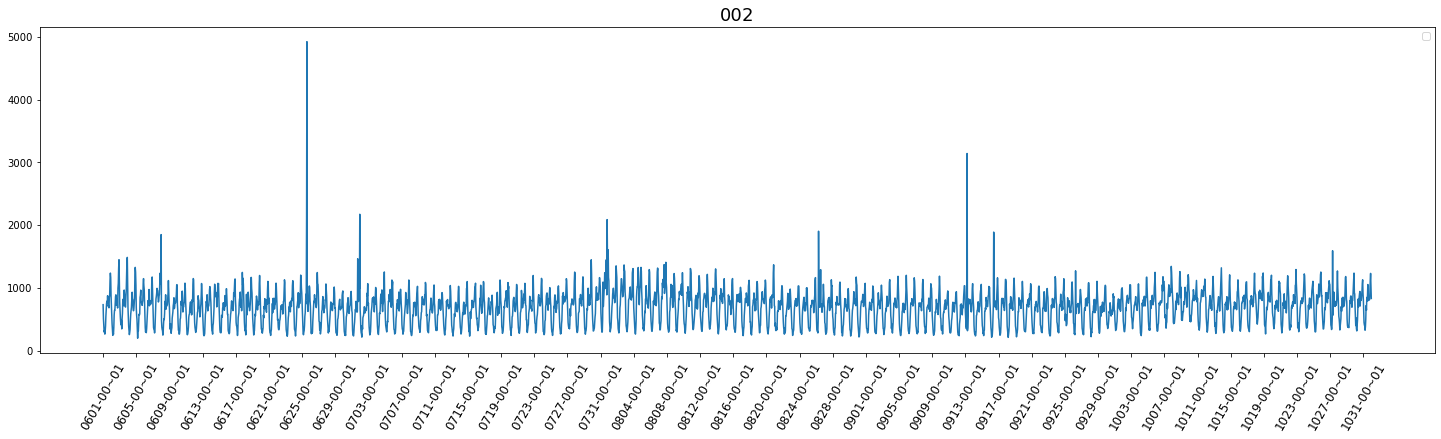

No handles with labels found to put in legend.


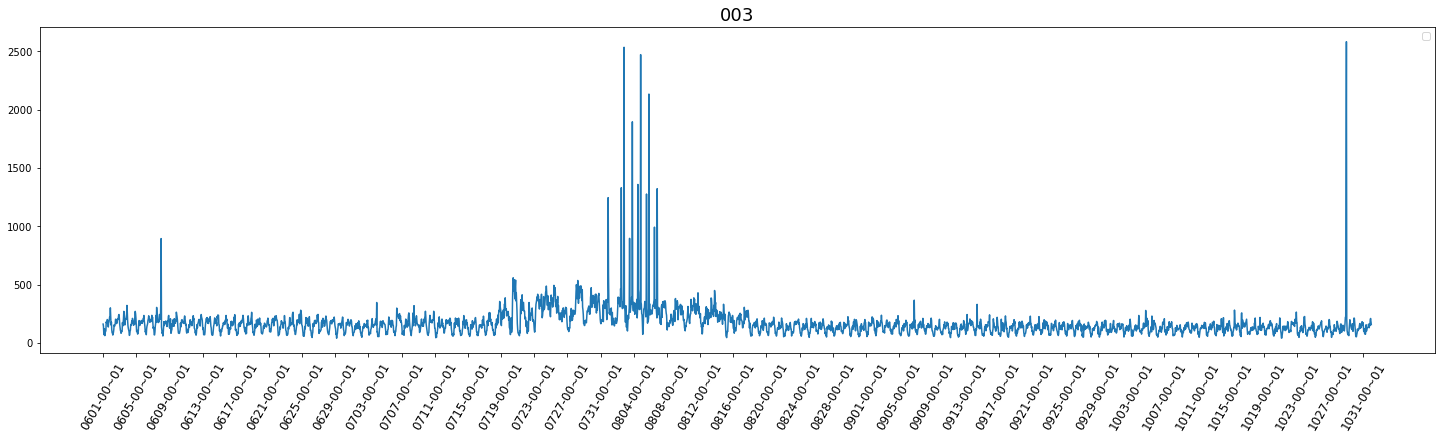

No handles with labels found to put in legend.


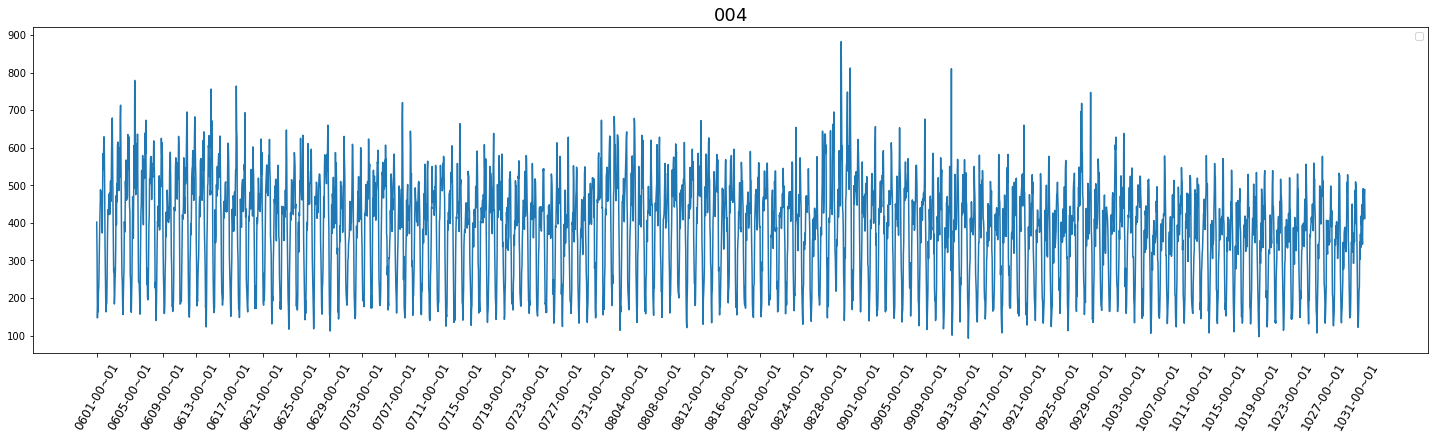

In [10]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [25, 6]
fig = plt.figure()

for feature in _dict:
    error_count = _dict[feature]
     
    plt.plot(error_date, error_count)
    plt.xticks(error_date[::96], fontsize=12, rotation=60)
    plt.legend(loc='best')
    plt.title(f'{feature}', fontsize=18)
    plt.show()

# Split training, testing, validation

In [27]:
column = []
_dict = {} # 'feature': [errorcount]

with open('./multivariate_06-09.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
    
    column = [c for c in data[0]]
    _dict = { i : [] for i in column }
    
    for row in data[1:]:
        for index in range(0, len(row)):
            col = column[index]
            if index == 0:
                _dict[col].append(row[index])
            else:
                _dict[col].append(int(row[index]))
                
with open('./multivariate_09-10.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
    
    column = [c for c in data[0]]
    
    for row in data[1:]:
        for index in range(0, len(row)):
            col = column[index]
            if index == 0:
                _dict[col].append(row[index])
            else:
                _dict[col].append(int(row[index]))

In [56]:
Column = Country + State + ErrorEventID
Column.insert(0, 'ErrorTime')

train = range(720, 2160) # 7~8
validation = range(0, 720) # 6
test = range(2160, 3672) # 9~10

In [47]:
row = []
for i in validation:
    tmp = []
    for feature, count_list in _dict.items():
        tmp.append(count_list[i])
    row.append(tmp)

with open('validation.csv', 'w', newline='') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(Column)

    for r in row:
        writer.writerow(r)

print('done')

done


In [48]:
row = []
for i in train:
    tmp = []
    for feature, count_list in _dict.items():
        tmp.append(count_list[i])
    row.append(tmp)

with open('train.csv', 'w', newline='') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(Column)

    for r in row:
        writer.writerow(r)

print('done')

done


In [57]:
row = []
for i in test:
    tmp = []
    for feature, count_list in _dict.items():
        tmp.append(count_list[i])
    row.append(tmp)

with open('test.csv', 'w', newline='') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(Column)

    for r in row:
        writer.writerow(r)

print('done')

done
